# Simulating the Beam-Weighted Foregroung
#### David W. Barker

## Purpose:
The purpose of this notebook is to create some beam-weighted foregrounds using ULSA for the foreground and Fatima's beam models for the beam.

The image below is pretty useful for remembering the frequency range we care about. Image is from Chitta Ranjan Das' ICPPA-2024 talk (International Conference on Particle Physics and Astrophysics)

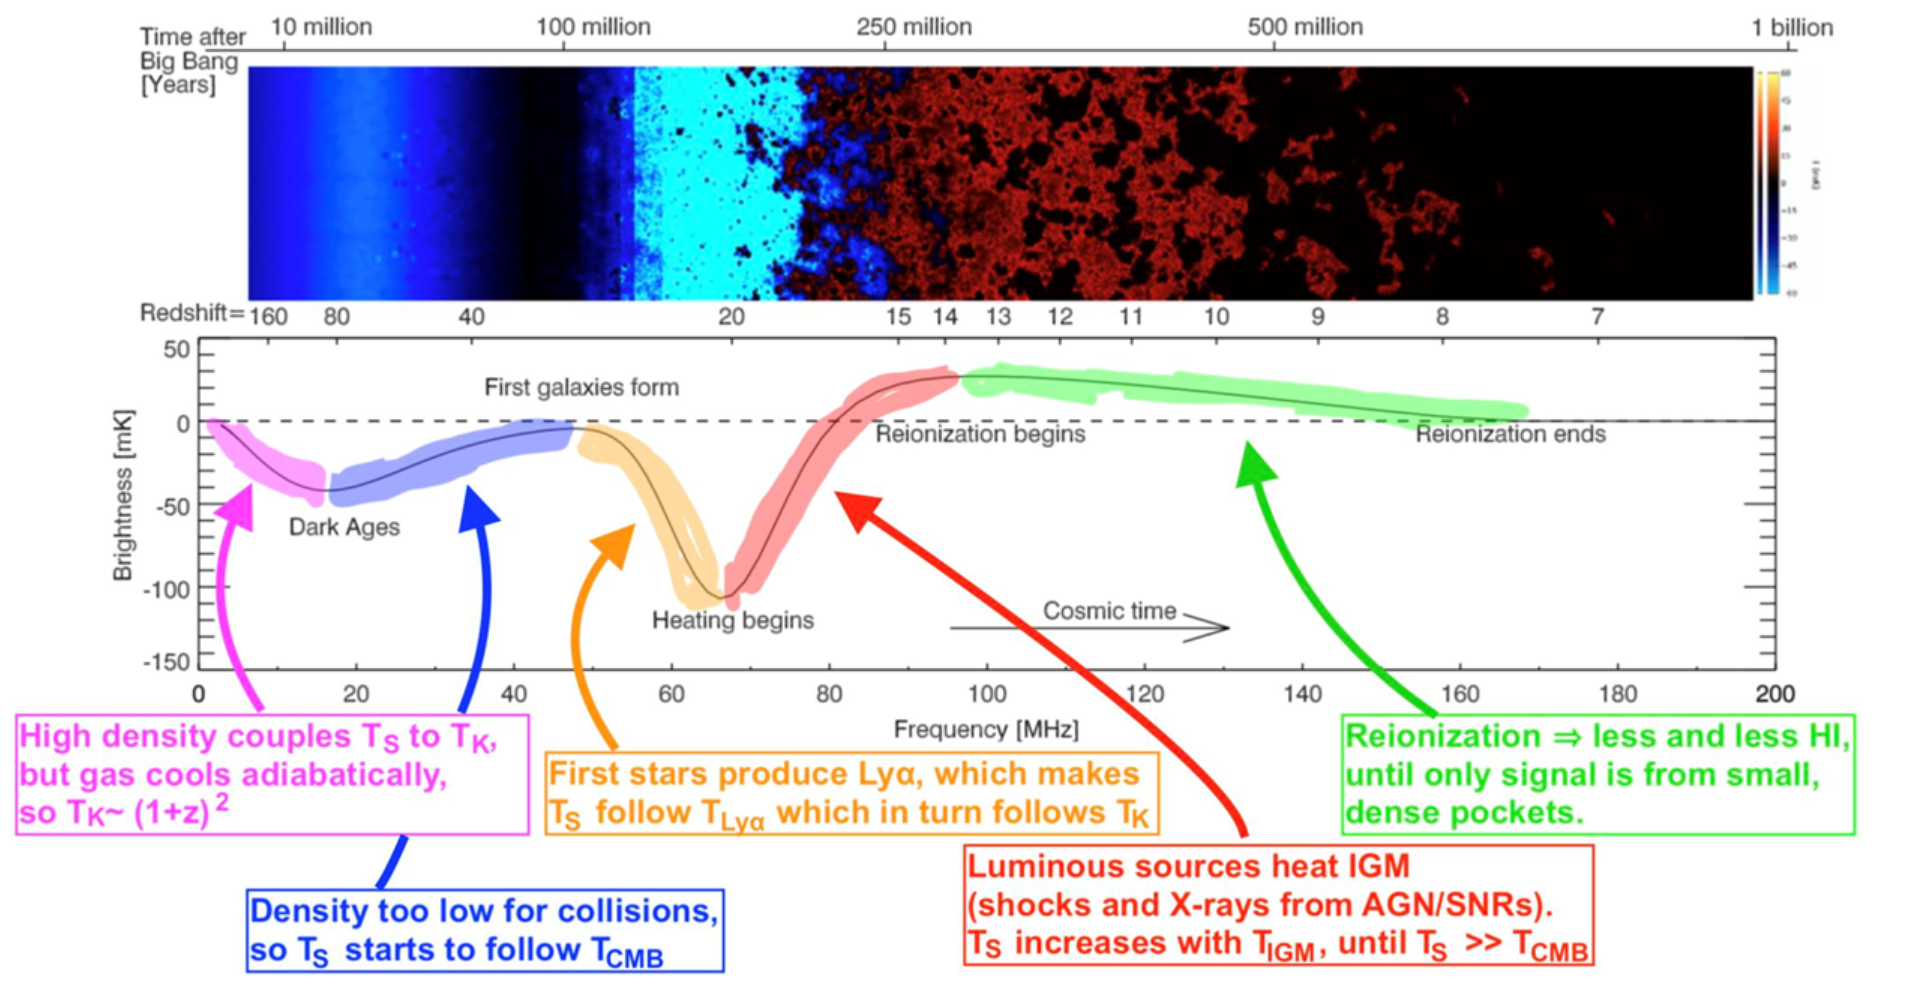

## Beam-weighted Foreground Model:

Let's start with the beam-weighted foreground model.

$\int_{0}^{\pi}\int_{0}^{2\pi}F(\theta, \nu)B(\theta,\nu)d\theta d\phi$

Where F is your foreground signal and B is your beam weighting. This is the total sky signal for a specific frequency.  Ideally, we would want to graph this as a function of frequency to get our signal, but it depends on where we are pointing our telescope, since the galactic center is not the same as the empty sky. The first step is creating a few rotated galaxies and then weighting those with a set of beams, each with different parameters.

In [1]:
# boiler plate for most pylinex 21-cm stuff

import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pylinex import Fitter, BasisSum, PolynomialBasis
import perses
from perses.models import PowerLawTimesPolynomialModel
from pylinex import Basis
import perses
# boiler plate stuff for healpy
import healpy as hp
from PIL import Image
import matplotlib.animation as animation
from astropy.io import fits
import os
import copy
from pylinex import Fitter, BasisSum, PolynomialBasis, MetaFitter, AttributeQuantity
from pylinex import Basis
from pylinex import TrainedBasis
import py21cmsig
import importlib
import corner
import lochness

In [101]:
# Imporant constants
NSIDE = 32 # resolution of the map
NPIX = hp.nside2npix(NSIDE)
NPIX   # total number of pixels (size of the array being used)
location = (-23.815,182.25)  # The lat lon location of the moon landing site
spice_kernels = "/home/dbarker7752/lochness/input/spice_kernels/" #location of the spice kernels

# Cosmological Parameters
H0 = 67.36     # Hubble constant 
h = H0/100     # H0
omM0 = 0.3152   # Omega matter today
omB0 = 0.0493   # Omega baryons today 
omK0 = 0        # Omega curvature today
omC0 = 0.2645   # Omega cold dark matter today 
#omR0 = 8.98e-5  # Omega radiation today
omR0=8.600000001024455e-05  # Omega radiation from 21cm FAST
omL0 = 0.6847   # Omega Dark Energy today

### Boilerplate arrays for healpy (changes with a change in resolution)
thetas = hp.pix2ang(NSIDE,np.arange(NPIX))[0]*(180/np.pi)
phis = hp.pix2ang(NSIDE,np.arange(NPIX))[1]*(180/np.pi)
coordinate_array = np.ones((NPIX,2))
for i in np.arange(NPIX):
    coordinate_array[i] = np.array([phis[i],thetas[i]])

# HASLAM map
gal = perses.foregrounds.HaslamGalaxy()
haslam_data=gal.get_map(39.93) # gets the actual array of the data for that haslam map

# ULSA map
ULSA_direction = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/000.fits")
ULSA_frequency = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/210.fits")
ULSA_constant = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/220.fits")

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map = ULSA_direction[0].data    # default galaxy map
test_times1 = [[2025,1,1,1,0,0],[2025,1,5,1,0,0]]   # list of times LOCHNESS will rotate the sky for 
frequency_array = np.array(range(1,51))   # list of frequencies we're evaluating at   

# modifies the galaxy map to not have the CMB (to make it consistent with the delta CMB convention of the signal)
galaxy_map_minCMB = copy.deepcopy(galaxy_map)
redshift_array = 1420.4/frequency_array-1
# This loop creates a CMB subtracted galaxy map to input into LOCHNESS
for i,j in enumerate(redshift_array):
    galaxy_map_minCMB[i] = galaxy_map[i] - py21cmsig.T_gamma(j)
galaxy_map_minCMB[np.where(galaxy_map_minCMB<0.0)] = 0   # Gets rid of the negatives that plague this ULSA map (not sure why they are they)
foreground_array_minCMB = lochness.LOCHNESS(spice_kernels,test_times1,location,galaxy_map=galaxy_map_minCMB).lunar_frame_galaxy_maps
foreground_array_minCMB[np.where(foreground_array_minCMB<0.0)] = 0

/home/dbarker7752/perses/perses/foregrounds/HaslamGalaxy.py:83: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  self._haslam_map_408 = hp.read_map(file_name, verbose=False)


Prepared Haslam map in 0.0878 s.
Furnsh-ing spice kernels...
Computing lunar simulation for time  [2025, 1, 1, 1, 0, 0]
Computing lunar simulation for time  [2025, 1, 5, 1, 0, 0]


In [ ]:
# This cell includes all of the functions we need for the beams

# allows us to convert a beam that is a function of angle to a beam as a function of pixel
def ang2pix_interpolator (data,coordinates=coordinate_array,normalization = 1):
    """Converts a 3-D beam map into a healpy format (1-D array per frequency, so technically 3-D to 2-D)
    
    Parameters
    =============================================================================================
    data: an interpolation function that takes a 2D array as its argument such as np.array([altitude, azimuth])
    normalization: The number to divide by to normalize the data. Default = 1 (assumes a normalized gain array)
    =============================================================================================
    Returns
    =============================================================================================
    data_healpy_map:  a 2-D array in the shape (frequency, 1-D healpy_map)"""

    # the point is to be able to input any size of beam array and not have to worry about empty spaces due to pixels not being filled it
    # this means we need to fill in the data if it hasn't been provided, which is very easy with an interpolation
    ### Interpolation
    data_healpy_map = data(coordinates)/normalization

    return data_healpy_map

## Next step is to loop through all the different beams and make the respective signal arrays
def signal_training_set(path,foreground_array,times,frequency_bins,mask_negatives=True):
    """ Creates an array that includes the beam-weighted foreground arrays with respective times of all the listed files. NOTE: Is not general and only applies to Fatima's beams. Need to change this at some point.
    Parameters
    ========================================================================================================
    path: the path that contains all of the files you wish to compute the signal for. Must be a string. Right now I've only designed the function to read an entire folder.
    foreground_array: Array of the rotated galaxy foreground. You can create this by inputting your desired galaxy map and times into the LOCHNESS function
                     Example: foreground_array = LOCHNESS(spice_kernels,time_array,location,galaxy_map = my_galaxy_map).lunar_frame_galaxy_maps
    times: the array of times that you used for your 
     function. Format is [[year,month,day,hour,minute,second],[year,month,day,hour,minute,second],...]
    frequency_bins: the number of frequency bins. Should be an interger.
    mask_negative":  Whether or not to mask the negative values. Should be true for galaxy maps and false for cosmological signals (since they are delta TCMB, which can be negative and often is)
    
    Returns
    ========================================================================================================
    signal_master_array: An array of all the signals for each file 
    sma_minCMB:  Same as signal_master_array, but with the CMB subtracted off"""

    parameter_set = np.ones((len(files),3))  # NOTE: the 3 corresponds to the 3 parameters in Fatima's beams, so not general to any beam.
    signal_master_array = np.zeros((len(files),len(times),frequency_bins))  # place holder for now
    for i,f in enumerate(files):
        array_element=signal_from_beams(fits_beam_master_array(f),foreground_array,times,frequency_bins,mask_negatives)
        signal_master_array[i] = array_element
        parameters = np.array(fits_beam_master_array(f)[2])
        parameter_set[i] = parameters

    return signal_master_array, parameter_set

def interpolator_for_STS(STS,new_frequency_bins):
    """Adds more x values to your signal training sets to work better within Pylinex
    
    Parameters
    ====================================================
    STS = Signal Training Set. The object created from the signal_training_set function
    new_frequency_bins: the number of frequency bins for the new STS. Should be an interger.
 
    Returns
    ====================================================
    new_STS = New signal training set with the new x_values"""
    new_STS = np.ones((len(STS),len(STS[0]),new_frequency_bins))  # creates a dummy array for later
    for t in range(len(STS[0])):  #picks out the time array length
        for i in range(len(STS)): #picks out number of sets in the training set
            STS_element_interpolator = scipy.interpolate.CubicSpline(range(1,len(STS[0][0])+1),STS[i][t]) # assumes we start at 1 MHz, creates the interpolation function
            STS_element = STS_element_interpolator(np.arange(1,51,(50/new_frequency_bins)))    # creates the element that will replace the index of the dummy array 
            new_STS[i][t] = STS_element

    return new_STS

def fits_beam_master_array (file_path):
    """Converts Kaja's beam files into a larger 3-D array of beams.
    Parameters
    ==============================================================================
    file_path: the path of the fits file of the beam. Must be a string.

    Returns
    ==============================================================================
    healpy_array = A healpy array that combines all the desired values
    beam_functions = an array of interpolations per frequency"""
    
    file = fits.open(file_path)   # opens the fit file to be used in our function
    data = file[8].data/(4*np.pi)  # normalizes the data. Note that the [8] is the gain part of this particular fits file convention (Fatima decided this convention)
    beam_functions = []
    ### This portion of the code makes the interpolation objects that will be combined together and converted to healpy arrays later.

    ## This mess creates our y array. Its takes very little time just way more lines of code than I think I actually need most likely
    array1 = np.zeros(361)
    for i in range(len(data[0])+90):  # we have to add the 90 here to get the values below the horizon. Fatima doesn't include below horizon, have to add it in ourselves.
        if i != 0:
            array_element=np.ones(361)*i
            array1=np.append(array1,array_element)

    array2 = np.arange(0,361)
    for j in range(len(data[0])+90):
        if j != 0:
            array_element = np.arange(0,361)
            array2 = np.append(array2,array_element) 
    ## ## ##

    y = np.array((array2,array1)).transpose()
    
    zeros = np.zeros(32490)
    for j in range(len(data)):
        d = data[j].flatten()  # creates our data array for plugging into the interpolator
        d= np.append(d,zeros)
        beam_function = scipy.interpolate.RBFInterpolator(y,d,neighbors=10)  # creates a function for the beams using an interpolator.
                                                                        # requires a 2-D array: np.array([phi,theta]) as an input.
        beam_functions.append(beam_function)

    healpy_array = np.array([ang2pix_interpolator(beam_functions[0])])
    for i in range(len(data)):
        if i == 0:
            None
        else:
            healpy_array=np.concatenate((healpy_array,np.array([ang2pix_interpolator(beam_functions[i])])),axis=0)
    parameter_array = []
    parameter_array.append((file[0].header["L"],file[0].header["TOP"],file[0].header["BOTTOM"])) 
    return beam_functions, healpy_array, parameter_array

## This function coverts a weighted foreground set (with all frequencies) into a signal (frequency vs temperature)
def signal_from_beams(beam_array,foreground_array,time_array,desired_frequency_bins,mask_negatives=True,normalize_beam=True):
    """Converts a weighted beam array into a monopole signal of frequency vs temperature
    Parameters
    =================================================================
    beam_array: An array of healpy maps for each frequency. The input should be from fits_beam_master_array. That function's output will match the required format of this input.
    foreground_array: Array of the rotated galaxy foreground. You can create this by inputting your desired galaxy map and times into the LOCHNESS function
                     Example: foreground_array = LOCHNESS(spice_kernels,time_array,location,galaxy_map = my_galaxy_map).lunar_frame_galaxy_maps
    time_array: Array of times you wish to evaluate this at. Format is [[year,month,day,hour,minute,second],[year,month,day,hour,minute,second],...]
    desired_frequency_bins: The number of frequency bins you desire.
    normalize_beam = Boolean as to wheter or not you would like to normalize the beam so that all weights add to 1. Sometimes beams are packaged in a way that actually
                     includes both the beam and the response function (how the antenna responds at each frequency), but technically the beam should not include this.
                     Normalization is set to True as default to remove the response function from beams. If it's already removed, it won't change anything anyways.
    
    Returns
    =================================================================
    signal: An array for the signal (frequency vs brightness temperature)"""

#### NOTE: we need to mask the beam to make the negative numbers equal to 0. There is a glitch with that blank spot in the ULSA map where it wants to massively inflate the negative value

# now let's apply the ULSA map and weight it using the beam and collect all the frequencies into a single array:
    frequency_bins = beam_array[1].shape[0]  # picks out the number of frequency bins in Fatima's beams. Won't work if she changes their format
    times = time_array
    signal = np.ones((len(times),frequency_bins,NPIX))
    for f in range(frequency_bins):
        signal_element = time_evolution(beam_array[1][f],foreground_array,"N/A",f,"N/A",times,animation=False,normalize_beam=normalize_beam)
        signal[:,f] = copy.deepcopy(signal_element)
    if mask_negatives:
        signal[np.where(signal<0.0)] = 0  # Makes all negatives 0's as they should be. Negative temperature makes no sense in this case, though negative signal does since its delta Tb
    # now let's add up all the pixels and bin them per frequency to get our monopole signa
    signal_sum = np.ones((len(times),frequency_bins))
    for t in range(len(times)):
        for f in range(frequency_bins):
            if normalize_beam:
                signal_sum[t][f] = np.sum(signal[t][f])
            else:
                signal_sum[t][f] = np.sum(signal[t][f])/(NPIX/2) # this creates our array of summed up signals, NPIX/2 is so that we don't add all the 0's that aren't in the beam NOTE: different if you add horizon
    
    new_signal_sum = np.ones((len(signal_sum),desired_frequency_bins))  # creates a dummy array for later
    for t in range(len(signal_sum)):  #picks out the time array length
        SS_element_interpolator = scipy.interpolate.CubicSpline(range(1,len(signal_sum[0])+1),signal_sum[t]) # assumes we start at 1 MHz, creates the interpolation function
        SS_element = SS_element_interpolator(np.arange(1,51,(50/desired_frequency_bins)))    # creates the element that will replace the index of the dummy array. Assumes a start and end frequency of 1 and 50 MHz
        new_signal_sum[t] = SS_element 
    
    return new_signal_sum

def signals_interpolator(STS,new_frequency_bins):
    """Adds more x values to your signal training sets to work better within Pylinex
    
    Parameters
    ====================================================
    STS = Signal Training Set. The object created from the signal_training_set function
    new_frequency_bins: the number of frequency bins for the new STS. Should be an interger.
 
    Returns
    ====================================================
    new_STS = New signal training set with the new x_values"""
    new_STS = np.ones((len(STS),len(STS[0]),new_frequency_bins))  # creates a dummy array for later
    for t in range(len(STS[0])):  #picks out the time array length
        for i in range(len(STS)): #picks out number of sets in the training set
            STS_element_interpolator = scipy.interpolate.CubicSpline(range(1,len(STS[0][0])+1),STS[i][t]) # assumes we start at 1 MHz, creates the interpolation function
            STS_element = STS_element_interpolator(np.arange(1,51,(50/new_frequency_bins)))    # creates the element that will replace the index of the dummy array 
            new_STS[i][t] = STS_element

    return new_STS

# needed for the plots
# This code was created using gemini AI (very minor changes)

def animate_images_time(image_folder, output_path, time_array,frequency, frame_duration=200):
    """
    Animates images in a folder and saves the animation as a GIF.

    Args:
        image_folder (str): Path to the folder containing the images.
        output_path (str): Path to save the output GIF file.
        time_array: The array of the times at which to evaluate.
        frequency: The frequency at which to evaluate.
        frame_duration (int, optional): Duration of each frame in milliseconds. Defaults to 200.
    """
    # image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))],key=int)
    image_files = []
    for i in range(len(time_array)):
        image_files.append(image_folder+f"{frequency}"+f"_time_step_{i}.png")

    fig, ax = plt.subplots()
    ims = []
    for image_file in image_files:
        img = Image.open(image_file)
        im = ax.imshow(img, animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=frame_duration, blit=True, repeat_delay=1000)
    ani.save(output_path, writer='pillow')
    plt.close(fig)

# let's create an animation of the time evolution of a specific beam weighted foreground at a specific frequency
def time_evolution (beam,foreground_array,save_location,frequency,label,time_array,location = location,norm=None,max=None,animation=True,normalize_beam=True):
    """Creates the  for a specific master beam
    
    Parameters
    =============================================================================
    beam: the healpy array that is to be mapped onto the sky. Should be (NPIX) shape. Just the one healpy array. Assumes zenith is at the top 
          edge of the mollview (function will rotate it to the center).
    foreground_array: the healpy array that is the galactic foreground, but already rotated. Should be (time steps,NPIX) shape.
                      NOTE: This could be calculated within this function, but it saves time to do it outside if your calculating 
                            multiple beams at the same timestep, then you can apply this to each of them instead of calculating each time.
    save_location: location you whish to save these plots (string)
    frequency: The frequency to evaluate at. Interger
    label: legend label of each plot (first part at least)
    time_array: The list of times that you wish to evaluate at.
    location: The lat lon of the LuSEE-Night lander. Default is the latest value I've seen from the mission details.
    max: The max value displayed on the mollview map.
    animation = Boolean as to whether or not you would like an animation of the beams to be made, cycling through frequency
    normalize_beam = Boolean as to wheter or not you would like to normalize the beam so that all weights add to 1. Sometimes beams are packaged in a way that actually
                     includes both the beam and the response function (how the antenna responds at each frequency), but technically the beam should not include this.
                     Normalization is set to True as default to remove the response function from beams. If it's already removed, it won't change anything anyways.
    Return
    =============================================================================
    saves the plots to the designated folder and also creates an animation in the same folder"""

    # Let's do some plotting
    foreground_array_mod = copy.deepcopy(foreground_array[:,frequency])  # this assumes that each index number associates the the same frequency number
                                                                        # NOTE: The deepcopy makes sure changes to foreground_array_mod don't change the original foreground_array
    beam_euler_angle = [0,90,90] # this rotates only the beam, not the galaxy, in order to match the convention of zenith being the center of the map
    rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(beam)
    if animation:
        for i,j in  enumerate(foreground_array_mod):
            if normalize_beam:
                foreground_array_mod[i] = j*rotated_beam/np.sum(rotated_beam) 
            else:
                foreground_array_mod[i] = j*rotated_beam
            hp.mollview(foreground_array_mod[i],title=label+ f" at {frequency}" + f" time step {i}",unit=r"$T_b$",min=0,norm=norm,max=max)
            plt.savefig(save_location+f"/{frequency}+MHz"+f"_time_step_{i}.png")
            plt.close()

        animate_images_time(save_location,save_location+"Animation.gif",time_array, frequency)
    else:
        for i,j in  enumerate(foreground_array_mod):
            if normalize_beam:
                foreground_array_mod[i] = j*rotated_beam/(np.sum(rotated_beam))
            else:
                foreground_array_mod[i] = j*rotated_beam       
    return foreground_array_mod

# Let's make a time array script for more easily constructing these time arrays
def time_array (path_to_spice_kernels,start_time,end_time,time_step):
    """"Creates a time array for inputing into the time_evolution functions
    Parameters
    ======================================================================================
    path_to_spice_kernels: The path that points to the spice kernels. Standard file address format.
    start_time: The first time step. Format is [year,month,day,hour,minute,second]
    end_time: The last time step. Same format as start_time. (May not be exact depending on time step)
    time_step: The amount of time in between the listed times. Must be in seconds.
    ts_unit:  The unit of the time step. Possible units are "YEARS", "MONTHS","DAYS","HOURS","MINUTES","SECONDS"

    Returns
    ======================================================================================
    A time array for plugging into the LOCHNESS class or the time_evolution function"""

    spice.furnsh(path_to_spice_kernels + 'naif0012.tls') #leap seconds
    spice.furnsh(path_to_spice_kernels + 'de440.bsp') #positions of planets
    spice.furnsh(path_to_spice_kernels + 'pck00011.tpc') #planetary constants

    # loading moon_pa kernels
    spice.furnsh(path_to_spice_kernels + 'moon_080317.tf')
    ##### We want to use MOON_PA for better accuracies #####
    spice.furnsh(path_to_spice_kernels + 'moon_assoc_pa.tf')
    spice.furnsh(path_to_spice_kernels + 'moon_pa_de421_1900-2050.bpc')

    time_array = []     # Empty placeholder array for use later
    et_array = np.array([])       # Empty placeholder array for use later  
    dt_start = datetime(year=int(start_time[0]), month=int(start_time[1]),day=int(start_time[2]), hour=start_time[3], minute=start_time[4],second=start_time[5])    # start time in datetime format
    dt_end = datetime(year=int(end_time[0]), month=int(end_time[1]),day=int(end_time[2]), hour=end_time[3], minute=end_time[4],second=end_time[5])     # end time in datetime format
    et_start = spice.datetime2et(dt_start)     # start time in ephemeris format (easier to step through via time_step)
    et_end = spice.datetime2et(dt_end)         # end time in ephemeris format
    time_spread = et_end - et_start       # the difference between start and end time in seconds
    steps = round(time_spread/time_step)     # number of steps to take, which determines the number of times to append to our time array
    et_element = et_start     # starts with the first time for the et_array
    for i in range(steps):     # populates an array for all of our time in ephemeris format
        et_array = np.append(et_array,et_element)
        et_element =+ et_element + time_step
    for i in et_array:    # converts ephemeris time to the format accepted by LOCHNESS
        element_list = []
        time_element = spice.et2datetime(i)
        element_list.append(time_element.year)
        element_list.append(time_element.month)
        element_list.append(time_element.day)
        element_list.append(time_element.hour)
        element_list.append(time_element.minute)
        element_list.append(time_element.second)
        time_array.append(element_list)
    return time_array

def make_cosmo_array(frequency_array,times):
    """A function that creates an array for the global 21 cm cosmological signal. The array will match the shape and size of the foreground arrays
    Parameters
    ==========================================================
    
    Returns
    ==========================================================
    cosmo_array: An array for the global 21cm signal that matches the foreground arrays' shapes"""
    cosmo_array = np.ones((len(times),len(frequency_array),NPIX))
    redshift_array = 1420.4/frequency_array-1 
    redshift_array = redshift_array[::-1] 
    dTb = py21cmsig.dTb(redshift_array,py21cmsig.camb_xe_interp,py21cmsig.Tk(redshift_array,omR0,omM0,omK0,omL0)[1],omB0,omM0)*10**(-3)
    dTb = dTb[::-1]
    for i,j in enumerate(dTb):
        cosmo_array[:,i,:] = dTb[i]

    return cosmo_array 

# I'm going to do a quick aside and make my own plotting function. Keith's isn't good enough. Can't save the figs.

def plot_fit (meta_fitter,plot_title,name=None,division_factor=1,save=False):
    """Plots the PYLINEX linear fit of a basis
    Parameters
    =========================================================
    meta_fitter: meta_fitter object from the Pylinex module.
    name: The name of the specific basis you want the values for. Default is None, which will give you the combined basis.
    x_values: The x_values you'd like to make up the x axis labels. Should be an array of values
    division_factor:  The factor to divide the basis_values by. Useful sometimes for converting from beam-weighted to true signal. Can be a signle number of equal sized array as basis_values
    save: The name of the saved file. Leave blank if you don't want to save the plot

    Returns
    =========================================================
    plot of the basis with the asssociated error"""

    basis_values = meta_fitter.subbasis_channel_mean(name)/division_factor
    error_values = meta_fitter.subbasis_channel_error(name)/division_factor
    

    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(15)
    ax.set_xlabel(r"$\nu (MHz)$",size=20)
    ax.set_ylabel(r"$\delta T_{b} (mK)$",size=20)
    ax.tick_params(axis='both', which='major', size=20)
    ax.tick_params(axis='both', which='minor', size=10)
    plt.plot(range(1,len(basis_values)+1),basis_values,color="red") # Assuming it starts at 1 MHz. To make this general I really need to make a starting frequency variable
    plt.fill_between(range(1,len(basis_values)+1), basis_values+error_values,basis_values-error_values,alpha=0.25,color="red")
    plt.xticks(ticks=np.arange(1,502,100),labels=np.array([1,10,20,30,40,50]),size=20)    # THis is NOT general at all. Only works for dark ages and my current array size. NOTE: Need to make this general
    plt.yticks(size=20)
    plt.title(plot_title,size=30)
    if save:
        plt.savefig(save)

    return basis_values,error_values

def narrowed_training_set(data,rms_mean,one_sigma_rms,training_set,training_set_parameters,sigma_tolerance = 5):
    """This uses the rms of the residuals to narrow the training set so that the included curves are only the curves within some 
     defined sigma of the rms of the noise.  This is useful for hammering down the wildly inaccurate curves from the training set
      so that PYLINEX doesn't lose its mind over them. PYLINEX does not do well with too large of a parameter space. Note that due
      to some issues with arrays, this only handles one time stamp at a time. You will need to loop through this function to 
      do all time stamps.
       
    Parameters
    ============================================================
    data: The simulated or real data that our training set will attempt to fit. Should be an array of the shape (number of time steps, frequency bins)
    rms_mean: The mean of the rms. See one_sigma_rms for a better understanding of how to get this if you're unsure.
    one_sigma_rms: This is the rms value that defines a one sigma deviation from the "correct" answer. The best way to calculate this in my opinion
                    is to use a bootstrapping method with your noise. This means just run several thousand iterations of random noise, determining
                    the rms for each run. Then use the standard deviation of those many runs as your one_sigma_rms.
    training_set: The first return of the signal_trainin_set function or expanded_training_set. The array that contains all of the curves that
                  your are attempting to fit the data to. Should be an array of the shape (number of curves, number of time steps, frequency bins)
    training_set_parameters: the second return of the signal_training_set function or expanded_training_set. The array should contain all of the
                            parameters associated with each individual training set curve. Should be size (number of curves, number of parameters)
    sigma_tolerance: The number of sigma from the data fit residual that you would like to include in the new, narrowed training set. 
                     Interger or float.
                  
    Returns
    =============================================================
    narrowed_set: A new, narrowed training set that contains the curves within the sigma_tolerance range.
    narrowed_parameters: The collection of parameters that correspond to the narrowed training set curves
    rms_array: An array of all the rms values of each curve. Important for some other functions.
    training_set: Just returns the same input parameter above. Important for some other functions.
    training_set_parameters: Just returns the same input parameter above. Important for some other functions."""

    # First step is to create the bootstrapped sigma from the data_fit_residual.
    # In more plain words: We take the signal we should get if the data was a perfect fit and calculate the rms. Then do this many times.
    
    rms_array= np.zeros((len(training_set)))  # creates dummy array for our rms values for each curve
    sigma_array = np.zeros_like(rms_array)    # create a dummy array for the distance in sigma that each curve is from the noise
    for i in range(len(training_set)):      # loops through all the curves, subtracts the data from them, and then calculates the rms for each.
        differencing_element = data - training_set[i]
        rms_element = np.sqrt(np.mean(differencing_element**2))
        rms_array[i] = rms_element    # creates an array of the rms values for each training set curve
        sigma_array[i] = np.abs(rms_element-rms_mean)/one_sigma_rms   # creates an array of the distance from the noise is sigma of each training set curve.
    narrowed_set=training_set[np.where(sigma_array<sigma_tolerance)]
    narrowed_set_parameters=training_set_parameters[np.where(sigma_array<sigma_tolerance)]

    return narrowed_set, narrowed_set_parameters, rms_array, training_set, training_set_parameters

## NOTE: This doesn't include multiple time stamps. Do we need to even bother? Something to think about.
def expanded_training_set(STS_data,STS_params,N,custom_parameter_range=np.array([0]),show_parameter_ranges=False):
    """Convert a signal_training_set output into a much larger training set by interpolating over the parameters per frequency
    This is basically a 1 dimensional MEDEA.
    
    Parameters
    ====================================================
    STS_data: An output of the signal_training_set function. As of writing this it is the first output, so variable[0]
                              would be the correct call if that variable was set to the output of that function. 
    STS_params: An output of the signal_training_set function. As of writing this it is the second output, so variable[1]
    N:  The number of curves you wish to have in this new training set
    custom_parameter_range: This will replace the automatically generator parameter range. Make sure it will still be within
                            the parameter range of the training set and is of the correct shape. Default to False since it's 
                            a bit more advanced of a parameter.

    Returns
    ====================================================
    expanded_training_set: A new training set interpolated from the old with N curves
    expanded_training_set_params: The associated parameters of the new training set
    new_data: This is an interpolator that allows you to plug in any parameter value and get the curve. Handy for some investigation work"""

    param_value_ranges_array = np.ones((len(STS_params[0]),2))   # dummy arrray for parameter ranges that will be populated later
    
    if custom_parameter_range.any() == 0:  # checks to see if you've set a cust range of parameters for the expanded training set
        for i in range(len(STS_params[0])):   # Here we start to populate the array of parameter ranges. I call [0] because all entries should have the same number of parameters
            pr_element = [STS_params[:,i].min(),STS_params[:,i].max()]
            param_value_ranges_array[i] = pr_element
    else:
        param_value_ranges_array=custom_parameter_range

    expanded_training_set = np.ones((N,len(STS_data[0]),len(STS_data[0][0])))    # dummy array for the expanded training set
    expanded_training_set_params = np.ones((N,len(STS_params[0])))   # dummy array for the parameters of this expanded set

    for n in range(N):   # this will create our list of new parameters that will be randomly chosen from within the original training set's parameter space.
        new_params = np.array([])
        for k in range(len(STS_params[0])):  # this will create a new set of random parameters for each instance
            p = param_value_ranges_array[k]
            new_params = np.append(new_params,np.random.random()*(p[1]-p[0])+p[0])
        expanded_training_set_params[n] = new_params
    for t in range(len(STS_data[0])):  # loops through the time steps
        for f in range(len(STS_data[0][0])):    # loops through all frequencies
            values = STS_data[:,t,f]
            new_data=scipy.interpolate.griddata(STS_params,values,expanded_training_set_params)
            expanded_training_set[:,t,f] = new_data   
    if show_parameter_ranges:
        print(param_value_ranges_array)

    return expanded_training_set, expanded_training_set_params, new_data

# Let's automate all of this:
def signal_extraction(data,rms_mean,one_sigma_rms,STS_data,STS_params,N=10000,iteration_limit=10,sigma_tolerance = 3):
    """Extracts a signal from data using a training set. This process includes two phases: 1) Brute force phase where we reduce the 
    parameter space of the training set (the hammer) and 2) PYLINEX, which then can use the narrow training set to best fit the signal
    (the scalpel). NOTE: This must be done per time stamp.
    
    Parameters
    =======================================================================
    data: The simulated or real data that our training set will attempt to fit. Should be an array of the shape (number of time steps, frequency bins)
    rms_mean: The mean of the rms. See one_sigma_rms for a better understanding of how to get this if you're unsure.
    one_sigma_rms: This is the rms value that defines a one sigma deviation from the "correct" answer. The best way to calculate this in my opinion
                    is to use a bootstrapping method with your noise. This means just run several thousand iterations of random noise, determining
                    the rms for each run. Then use the standard deviation of those many runs as your one_sigma_rms.
    STS_data: The first return of the signal_trainin_set function or expanded_training_set. The array that contains all of the curves that
                  your are attempting to fit the data to. Should be an array of the shape (number of curves, number of time steps, frequency bins)
    STS_params: the second return of the signal_training_set function or expanded_training_set. The array should contain all of the
                            parameters associated with each individual training set curve. Should be size (number of curves, number of parameters)
    sigma_tolerance: The number of sigma from the data fit residual that you would like to include in the new, narrowed training set. 
                     Interger or float.
    N:  The number of curves to create per training set. Default is 10000. Seems to work fast and well enough.
    iteration_limit: The number of iterations your willing to do to try to get to the very narrowed training set.
                  

    Returns
    ======================================================================="""

    # for t in len(training_set[0]):
    t=0
    custom_parameter_range = np.array([0])
    original_set = expanded_training_set(STS_data,STS_params,N,custom_parameter_range)
    training_set = STS_data
    training_set_parameters = STS_params
    narrow_set = narrowed_training_set(data,rms_mean,one_sigma_rms,training_set,training_set_parameters,sigma_tolerance)
    iteration_count=0
    print("phase 1")
    while (len(narrow_set[0]) < 5) & (iteration_count < iteration_limit):   # this will pull out the 5 closest curves if there aren't enough within 3 sigma
        sorted_set = copy.deepcopy(narrow_set[2])
        sorted_set.sort()
        sorted_set = sorted_set[0:5]
        sorted_indices = np.array([])
        for i in sorted_set:
            sorted_indices_element = np.where(narrow_set[2] == i)[0][0]
            sorted_indices = np.append(sorted_indices,sorted_indices_element)
        sorted_indices.sort()
        close_5=np.ones((5,len(narrow_set[4][0])))   
        for n,i in zip(range(5),sorted_indices):    # this loop is due to the fact that numpy isn't being nice with masked array right now
            close_5[n] = narrow_set[4][int(i)]
        close_5T = np.transpose(close_5)
        new_parameter_range = np.zeros((len(STS_params[0]),2))
        for i in range(len(new_parameter_range)):
            spread = (close_5T[i].max()-close_5T[i].min())*1.32
            min_value = close_5T[i].min()-spread   # sets the minimum value of the parameter
            max_value = close_5T[i].max()+spread   # set the maximum value of the parameter
            if min_value < STS_params[:,i].min():       # ensures we don't go out of our original parameter range
                min_value = STS_params[:,i].min()       
            if max_value > STS_params[:,i].max():       # ensures we don't go out of our original parameter range
                max_value = STS_params[:,i].max()                            
            new_parameter_range[i] = [min_value,max_value]  # this adds a margin to the parameters sampled to ensure the answer isn't missed
        new_set = expanded_training_set(STS_data,STS_params,N,custom_parameter_range=new_parameter_range)
        narrow_set = narrowed_training_set(data,rms_mean,one_sigma_rms,new_set[0],new_set[1],sigma_tolerance)
        iteration_count += 1
        print(f"iteration count: {iteration_count}")
    
    # this will iterate over all the curves within 3 sigma until a training set is made that contains N*0.995 curves
    old_narrow_set_length = 0
    print("phase 2")
    while (len(narrow_set[0]) < int(N*0.995)) & (iteration_count < iteration_limit) & (len(narrow_set)>=old_narrow_set_length):  
        new_parameter_range = np.zeros((len(STS_params[0]),2))
        if iteration_count == 0:
            for i in range(len(STS_params[0])):   # creates our new parameter range from the starting parameters (if you didn't loop through the <5 one)
                min_value = STS_params[:,i].min()  # sets the minimum value of the parameter
                max_value = STS_params[:,i].max()  # set the maximum value of the parameter
                new_parameter_range[i] = [min_value,max_value]
        else:
            for i in range(len(new_parameter_range)):   # creates our new, narrowed, parameter set
                spread = (narrow_set[1][:,i].max()-narrow_set[1][:,i].min())*1.32
                min_value = narrow_set[1][:,i].min()-spread   # sets the minimum value of the parameter
                max_value = narrow_set[1][:,i].max()+spread   # set the maximum value of the parameter
                if min_value < STS_params[:,i].min():       # ensures we don't go out of our original parameter range
                    min_value = STS_params[:,i].min()       
                if max_value > STS_params[:,i].max():       # ensures we don't go out of our original parameter range
                    max_value = STS_params[:,i].max()                            
                new_parameter_range[i] = [min_value,max_value]  # this adds a margin to the parameters sampled to ensure the answer isn't missed
        new_set = expanded_training_set(STS_data,STS_params,N,custom_parameter_range=new_parameter_range)
        old_narrow_set_length = len(narrow_set[0])  # this stores the old narrow_set length for use in the boolean of this loop
        narrow_set = narrowed_training_set(data,rms_mean,one_sigma_rms,new_set[0],new_set[1],sigma_tolerance)
        iteration_count += 1
        print(f"iteration count: {iteration_count}")

    # depending on your number of variables, eventually you'll just be dancing around combination of variables with the loop above,
    # and you won't really get anywhere. when that happens, we move on to the final loop:
    print("phase 3")
    while (len(narrow_set[0]) < int(N*0.995)) & (iteration_count < iteration_limit):
        sorted_set = copy.deepcopy(narrow_set[2])
        sorted_set.sort()
        sorted_set = sorted_set[0:5]
        sorted_indices = np.array([])
        for i in sorted_set:
            sorted_indices_element = np.where(narrow_set[2] == i)[0][0]
            sorted_indices = np.append(sorted_indices,sorted_indices_element)
        sorted_indices.sort()
        close_5=np.ones((5,len(narrow_set[4][0])))   
        for n,i in zip(range(5),sorted_indices):    # this loop is due to the fact that numpy isn't being nice with masked array right now
            close_5[n] = narrow_set[4][int(i)]
        close_5T = np.transpose(close_5)
        new_parameter_range = np.zeros((len(STS_params[0]),2))
        for i in range(len(new_parameter_range)):
            spread = (close_5T[i].max()-close_5T[i].min())*1.32
            min_value = close_5T[i].min()-spread   # sets the minimum value of the parameter
            max_value = close_5T[i].max()+spread   # set the maximum value of the parameter
            if min_value < STS_params[:,i].min():       # ensures we don't go out of our original parameter range
                min_value = STS_params[:,i].min()       
            if max_value > STS_params[:,i].max():       # ensures we don't go out of our original parameter range
                max_value = STS_params[:,i].max()                            
            new_parameter_range[i] = [min_value,max_value]  # this adds a margin to the parameters sampled to ensure the answer isn't missed
        new_set = expanded_training_set(STS_data,STS_params,N,custom_parameter_range=new_parameter_range)
        narrow_set = narrowed_training_set(data,rms_mean,one_sigma_rms,new_set[0],new_set[1],sigma_tolerance)
        iteration_count += 1
        print(f"iteration count: {iteration_count}")

    return narrow_set, data

# To see what element in the training set was the closest to this:
def closest_curve(data,training_set_curves,training_set_parameters):
    """Finds the closest curve in the training set from the PYLINEX output.
    
    Parameters
    ====================================================
    data = The fitter.subbasis_channel_mean("{name of basis you're extracting}") array that represents the model Pylinex recreated. Shape (frequency bins)
    training_set_curves: The full list of curves that Pylinex used to fit its model.  Shape (number of curves, time stamps, frequency bins)
    training_set_parameters: The associated parameters with the training set curves. Shape (number of curves, number of parameters)

    Returns
    ===================================================
    closest_curve_parameters: The parameters of the curve with the smallest RMS difference to the Pylinex model.
    closest_curve_array: The array of the curve with the smallest RMS difference to the Pylinex model. """

    rms_array = np.array([])
    t=0
    for c in training_set_curves[:,0,:]:
        rms_element = np.sqrt(np.mean((data - c)**2))
        rms_array = np.append(rms_array,rms_element)
    min_index = np.where(rms_array == rms_array.min())[0][0]
    closest_curve_parameters = training_set_parameters[min_index]
    closest_curve_array = training_set_curves[min_index]

    return closest_curve_parameters, closest_curve_array

def simulation_run (beam_file,foreground_array,time_array,dnu,dt,omR0,omM0,omK0,omL0,omB0):
    """Creates a simulated data curve.
    
    NOTE: Not general right now. Only works in the range of 1-50 MHz. Easy fix, but don't want to do that right now, since it's not needed.
    NOTE: Also not general because the radiometer noise is built into the function (which is fine for anything I'll be doing). 

    Parameters:
    ====================================================================
    training_set_curves: The full list of curves that Pylinex used to fit its model.  Shape (number of curves, time stamps, frequency bins)
    training_set_parameters: The associated parameters with the training set curves. Shape (number of curves, number of parameters)
    beam_file = The file that contains the beam_arrays
    foreground_array: the healpy array that is the galactic foreground, but already rotated. Should be (time steps,NPIX) shape.
                      NOTE: This could be calculated within this function, but it saves time to do it outside if your calculating 
                            multiple beams at the same timestep, then you can apply this to each of them instead of calculating each time.
    time_array: Array of times you wish to evaluate this at. Format is [[year,month,day,hour,minute,second],[year,month,day,hour,minute,second],...]
    dnu: The bin size of the frequency bins. For the noise function.
    dt: Integration time. For the noise function.
   
    
    Returns
    ====================================================================
    simulated_data = An array of the simulated data as Temperature vs Frequency"""

    # Noise function
    sigT = lambda T_b, dnu, dt: T_b/(np.sqrt(dnu*dt))

    # Loads in a beam and a signal
    beam=fits_beam_master_array(beam_file)  # loads in a test beam
    frequency_array = np.array(range(1,51))
    redshift_array = 1420.4/frequency_array-1 
    redshift_array = redshift_array[::-1]      # need to convert to redshift since all of our functions are in redshift
    dTb=py21cmsig.dTb(redshift_array,py21cmsig.camb_xe_interp,py21cmsig.Tk(redshift_array,omR0,omM0,omK0,omL0)[1],omB0,omM0)*10**(-3)   # Need to convert back to Kelvin
    dTb=dTb[::-1]   # You have to flip it again because of the way dTb calculates based on redshift (needs previous higher redshift to calculate next redshift)

    # Let's now add this to our galaxy map
    signal_foreground_array = np.zeros_like(foreground_array)
    for t in range(len(foreground_array)):
        for i,j in enumerate(dTb):
            signal_foreground_array[t][i] = foreground_array[t][i]+j   # adds the signal to each frequency

    # Now let's weight this using a beam and LOCHNESS to rotate it
    simulation_test = signal_from_beams(beam,signal_foreground_array,time_array,50) #the non-interpolated version with only 50 frequency bins

    # Now we add radiometer noise

    for i in range(len(time_array)):
        simulation_test[i] = np.random.normal(simulation_test[i],sigT(simulation_test[i],dnu,dt))

    signal_only = dTb  # the non-interpolated version with only 50 frequency bins
    foreground_only = signal_from_beams(beam,foreground_array,time_array,50)

    return simulation_test, signal_only, foreground_only, noise_only

def multi_antenna_signal_extraction(signal_set,n_antenna,signal_extraction_return,dnu,dt,beam_file,foreground_array,time_array,omR0,omM0,omK0,omL0,\
                                    omB0,IC="DIC",plot=True,save=False,plot_title="Multi-Antenna Signal Extraction"):
    """Does signal extraction for a defined number of antennae.

    NOTE: Only works for foreground and signal right now. Add more later.

    Parameters
    =========================================================
    signal_set: The training set for the signal
    n_antenna: number of antennae. Interger
    signal_extraction_return: The return of the signal_extraction function
    dnu: The bin size of the frequency bins. For the noise function.
    dt: Integration time. For the noise function.
    training_set_curves: The full list of curves that Pylinex used to fit its model.  Shape (number of curves, time stamps, frequency bins)
    training_set_parameters: The associated parameters with the training set curves. Shape (number of curves, number of parameters)
    beam_file = The file that contains the beam_arrays
    foreground_array: the healpy array that is the galactic foreground, but already rotated. Should be (time steps,NPIX) shape.
                      NOTE: This could be calculated within this function, but it saves time to do it outside if your calculating 
                            multiple beams at the same timestep, then you can apply this to each of them instead of calculating each time.
    time_array: Array of times you wish to evaluate this at. Format is [[year,month,day,hour,minute,second],[year,month,day,hour,minute,second],...]
    IC: The type of information criteria that Pylinex will use to choose the best number of basis vectors
    plot: Wether or not to plot the fit.
    save: Wether or not to save the plot.

    Return
    =========================================================
    signal_array = Array of the new weighted signal
    signal_error = Error of the new weighted signal"""

    # Noise function
    sigT = lambda T_b, dnu, dt: T_b/(np.sqrt(dnu*dt))

    signal_means = np.zeros((n_antenna,len(signal_extraction_return[1][0])))
    signal_errors = np.zeros((n_antenna,len(signal_extraction_return[1][0])))

    # does the Pylinex fit a number of times equal to the number of antennae
    t=0
    for n in range(n_antenna):
        sim_data = simulation_run(beam_file,foreground_array,time_array,dnu,dt,omR0,omM0,omK0,omL0,omB0)[0][t]
        #### Pylinex Fit #####
        noise_level = sigT(sim_data,dnu,dt)
        foreground_training_set_array = copy.deepcopy(signal_extraction_return[0][0][:,t,:])
        foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=50,error=noise_level)
        signal_basis = TrainedBasis(training_set=signal_set[0], num_basis_vectors=50,error=noise_level)
        temperatures = sim_data
        basis_sum = BasisSum(["foreground","signal"],[foreground_basis, signal_basis])
        quantity = AttributeQuantity(IC)
        dimension = [{'foreground' : np.arange(1,20)}, {'signal' : np.arange(1,2)}]   # if you reduce the range to around 5 and 2, then it will probably fit really well
        meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
        fitter = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
        num_foreground_terms = fitter.sizes['foreground']
        num_signal_terms = fitter.sizes['signal']
        print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
        print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
        print(fitter.subbasis_channel_mean("signal").min())
        print(fitter.subbasis_channel_error("signal")[np.where(fitter.subbasis_channel_mean("signal")==fitter.subbasis_channel_mean("signal").min())][0])
        fitter.plot_subbasis_fit(nsigma=1, name="signal", x_values=np.arange(1,51,(50/len(sim_data))),\
            colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)', title=plot_title \
            '',\
            show=True, full_error_first=True,show_noise_level=False)
        signal_means[n] = fitter.subbasis_channel_mean("signal")
        signal_errors[n] = fitter.subbasis_channel_error("signal")**2
    total_signal_mean = np.mean(signal_means,axis=0) 
    total_signal_error = np.sqrt(np.sum(signal_errors,axis=0))/n_antenna
    if plot:
        fig, ax = plt.subplots()
        fig.set_figheight(10)
        fig.set_figwidth(15)
        ax.set_xlabel(r"$\nu (MHz)$",size=20)
        ax.set_ylabel(r"$\delta T_{b} (mK)$",size=20)
        ax.tick_params(axis='both', which='major', size=20)
        ax.tick_params(axis='both', which='minor', size=10)
        plt.plot(range(1,len(total_signal_mean)+1),total_signal_mean,color="red") # Assuming it starts at 1 MHz. To make this general I really need to make a starting frequency variable
        plt.fill_between(range(1,len(total_signal_mean)+1), total_signal_mean+total_signal_error,total_signal_mean-total_signal_error,alpha=0.25,color="red")    # THis is NOT general at all. Only works for dark ages and my current array size. NOTE: Need to make this general
        plt.yticks(size=20)
        plt.xticks(size=20)
        plt.title(plot_title,size=30)
        if save:
            plt.savefig(save)
    print(total_signal_mean[17])
    print(total_signal_error[17])

    return total_signal_mean, total_signal_error



In [5]:
rms_array = np.array([])
frequency_bins = 50
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_50[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

N=10000
frequency_array=np.arange(1,51)
parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
signal_training_set_lambdaCDM=py21cmsig.lambdaCDM_training_set(frequency_array,parameter_array,N)

rms mean is 6.506472740599404
rms std is 4.3605431564077834


In [ ]:
# This loads in your raw training set
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]
# varied_regolith_training_set = interpolator_for_STS(varied_regolith_training_raw,500)

# Noise parameters
dnu = 1e6
dt = 1000*3600 # first number is the number of hours of integration time

# Beam used for the simulated data
beam_file = files[1]

# times
time_array = test_times1

# foreground array
foreground_array = foreground_array_minCMB

# Our simulation function
simulation_test_50 = simulation_run(beam_file,foreground_array,time_array,dnu,dt,omR0,omM0,omK0,omL0,omB0)


Minimizing DIC over grid.
The MetaFitter chose 3 foreground terms based on DIC minimization.
The MetaFitter chose 1 signal terms based on DIC minimization.
-0.037691441476066075
0.015217047971235124


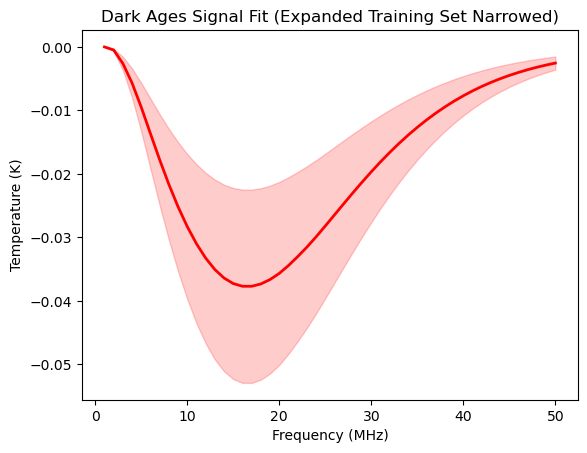

Minimizing DIC over grid.
The MetaFitter chose 5 foreground terms based on DIC minimization.
The MetaFitter chose 1 signal terms based on DIC minimization.
-0.04363998559973231
0.01621414936168603


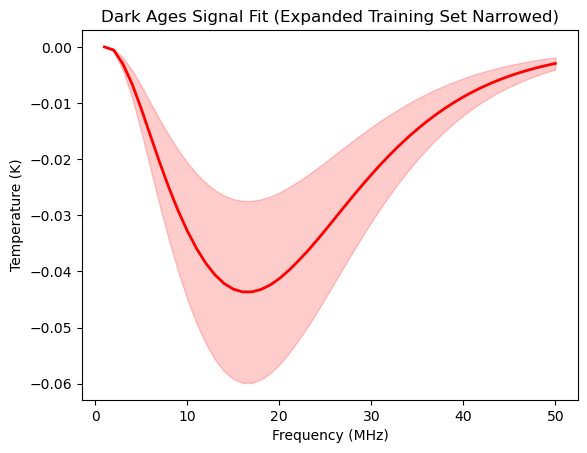

Minimizing DIC over grid.
The MetaFitter chose 5 foreground terms based on DIC minimization.
The MetaFitter chose 1 signal terms based on DIC minimization.
-0.04937031465861154
0.0155725711371282


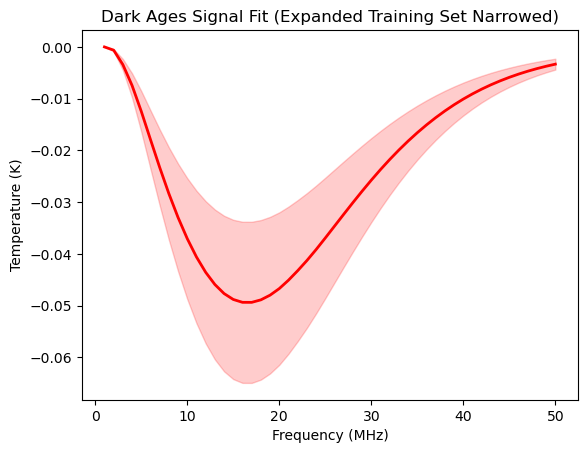

Minimizing DIC over grid.
The MetaFitter chose 3 foreground terms based on DIC minimization.
The MetaFitter chose 1 signal terms based on DIC minimization.
-0.019991568180422064
0.015217044804522344


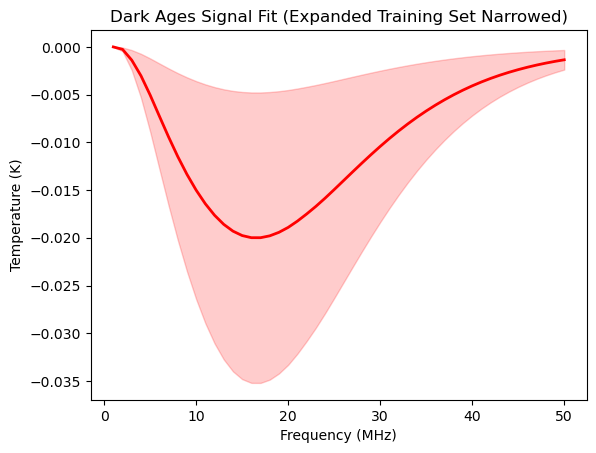

-0.037303257432623936
0.007703839378598316


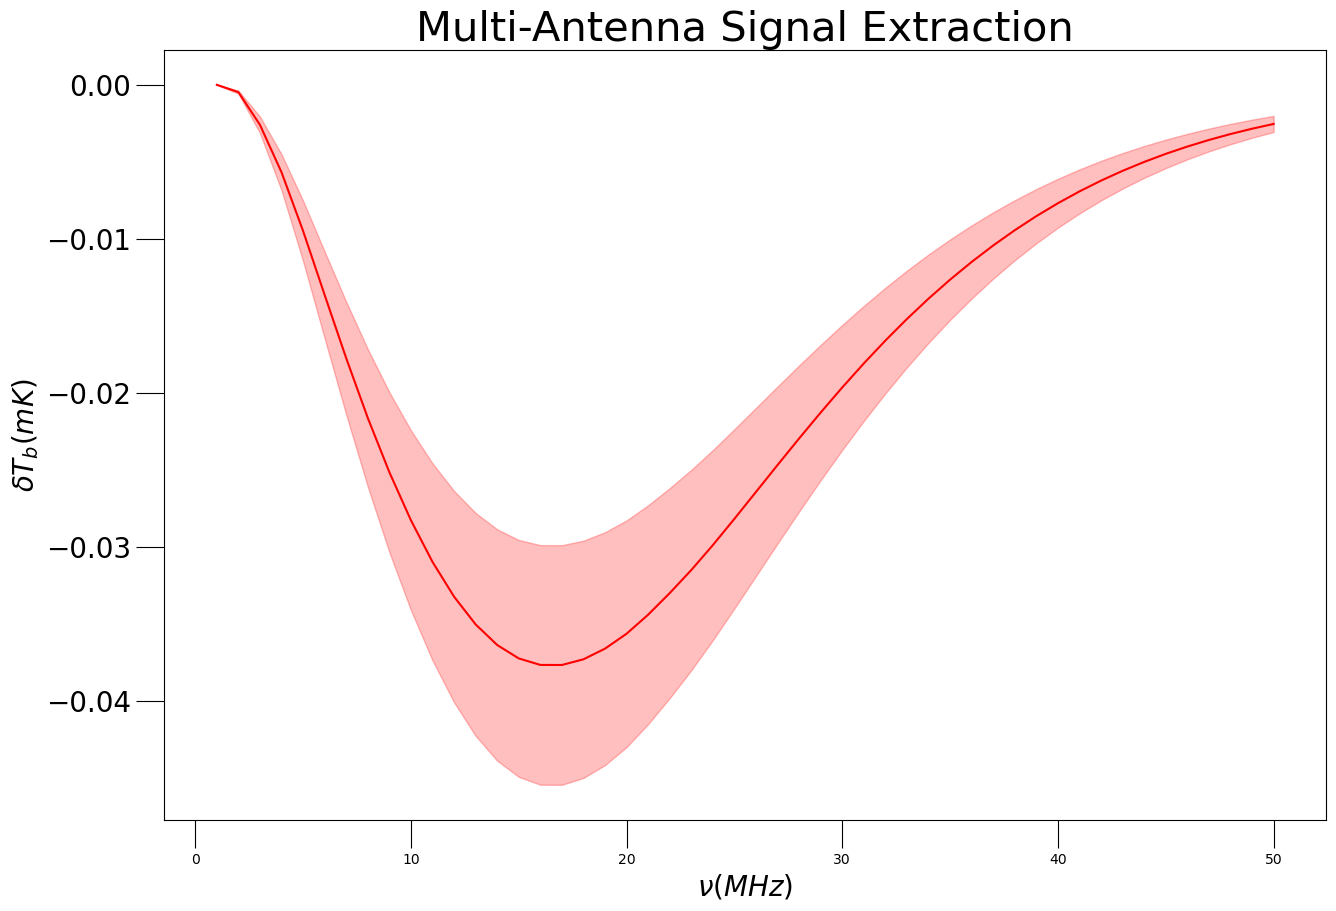

In [455]:
# for multi antenna
number_of_antennae = 4
signal_extraction_return = test12
multi_antenna = multi_antenna_signal_extraction(signal_training_set_lambdaCDM,number_of_antennae,signal_extraction_return,dnu,dt,beam_file,\
                                foreground_array,time_array,omR0,omM0,omK0,omL0,omB0,"DIC")

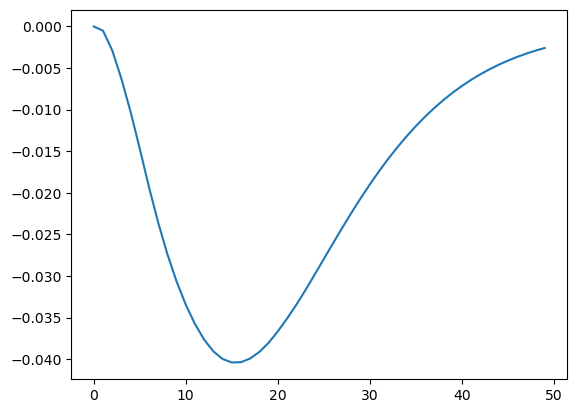

In [ ]:
np.where(test12[0][2] == test12[0][2].min())

# plt.plot(simulation_test_50t[0][0] - test12[0][0][4277][0])

minus = simulation_test_50t[0][0] - test12[0][0][4277][0]

rms_array=np.array([])
for c in signal_training_set_lambdaCDM[0]:
    rms = np.sqrt(np.mean((minus-c)**2))
    rms_array = np.append(rms_array,rms)

plt.plot(signal_training_set_lambdaCDM[0][5402])



In [454]:
# Bayesian Posterior focussing on the regolith parameters

Bayesian_training_set_beams = signal_extraction(simulation_test_50[0],rms_mean,rms_std,varied_regolith_training_set_raw,\
                                          varied_regolith_training_set_raw_params,sigma_tolerance=6,N=10000)[0]

phase 1
iteration count: 1
iteration count: 2
phase 2
iteration count: 3
phase 3
iteration count: 4


In [411]:
# Rover info (not accurate, just a complete guess that doesn't matter right now)
rover_mean = [1.0,3.4]
rover_std = [0.05,0.15]

derp = Bayesian_joint_posterior(simulation_test_50[0],Bayesian_training_set_beams,rms_mean,rms_std,Bayesian_training_set_beams[2])
derp

(array([0.99997324, 3.40120307, 4.6       ]),
 array([0.00189846, 0.00278393, 0.        ]),
 array([[1.01137569e+08, 2.32055889e+07, 9.02623177e+06, 4.49930214e+06,
         2.59741624e+06, 1.64891833e+06, 1.11976586e+06, 7.97157724e+05,
         5.89282076e+05, 4.48319862e+05, 3.50460376e+05, 2.80069373e+05,
         2.27788894e+05, 1.88059909e+05, 1.57335322e+05, 1.33200619e+05,
         1.13981377e+05, 9.85722529e+04, 8.60735952e+04, 7.58206669e+04,
         6.73909695e+04, 6.04301948e+04, 5.46141295e+04, 4.94941970e+04,
         4.45741018e+04, 3.98908968e+04, 3.58613726e+04, 3.25321834e+04,
         2.97439253e+04, 2.73445908e+04, 2.52321624e+04, 2.33409629e+04,
         2.16345694e+04, 2.00846056e+04, 1.86723177e+04, 1.73821799e+04,
         1.61971629e+04, 1.50961902e+04, 1.40669437e+04, 1.31106095e+04,
         1.22252997e+04, 1.14051662e+04, 1.06419128e+04, 9.93205335e+03,
         9.27682115e+03, 8.67452735e+03, 8.12024493e+03, 7.60808262e+03,
         7.13769233e+03, 6.71149

In [470]:
Bayesian_training_set_signal = signal_training_set_lambdaCDM
signal_rms_curve= np.sqrt(np.mean((multi_antenna[0] - signal_training_set_lambdaCDM[0])**2,axis=0))

# create our rms_mean and rms_std based on our PYLINEX extraction
# for c in test12[0][0] 

# The mean signal from the labmda CDM model
frequency_array = np.array(range(1,51))
redshift_array = 1420.4/frequency_array-1 
redshift_array = redshift_array[::-1]      # need to convert to redshift since all of our functions are in redshift
dTb=py21cmsig.dTb(redshift_array,py21cmsig.camb_xe_interp,py21cmsig.Tk(redshift_array,omR0,omM0,omK0,omL0)[1],omB0,omM0)*10**(-3)   # Need to convert back to Kelvin
dTb=dTb[::-1] 

In [417]:
signal_rms_curve.max()

0.00559025325996169

In [ ]:

derp2 = Bayesian_joint_posterior(simulation_test_50[0],Bayesian_training_set_signal,rms_mean,rms_std,rms_per_curve = 0, gaussian_model = True, \
                                gaussian_means_model=dTb,gaussian_sigmas_model=multi_antenna[1])

1.0

In [ ]:
# We should throw in signal_extraction into this function, but for speed, I'm going to skip that until I finalize this function

def Bayesian_joint_posterior (data,training_set,rms_mean,rms_std, rms_per_curve, gaussian_model=False, gaussian_prior=False, gaussian_means_model = None,\
                               gaussian_sigmas_model = None, gaussian_mean_prior = None, gaussian_sigmas_prior =None, print_parameter_range = False,t=0):
    """Calculates the Bayesian joint posterior distribution of your training set
    
    Parameters
    ===========================================================
    data: your data. Should be an array of shape (frequency bins)
    training_set: narrowed_training_set or signal_extraction return. Should be the shape (nuber of training set curves, frequency bins)
    rms_mean: The mean of the rms. See one_sigma_rms for a better understanding of how to get this if you're unsure.
    rms_std: This is the rms value that defines a one sigma deviation from the "correct" answer. The best way to calculate this in my opinion
                    is to use a bootstrapping method with your noise. This means just run several thousand iterations of random noise, determining
                    the rms for each run. Then use the standard deviation of those many runs as your one_sigma_rms.
    rms_per_curve: The rms value of the curve vs the data for each curve. Should be the shape (curves,time_step)
    gaussian_model: If True, it means your model priors are gaussian and you need to provide a mean and sigma for that distribution
    gaussian_prior: If True, it means your priors are gaussian and you need to provide a mean and sigma for that distribution
    gaussian_means_model: Mean for gaussian of the model priors. This is actually going to be an array of the curve that is the mean of the model
                          This is usually made in PYLINEX as a fitter.subbasis_channel_mean("signal") argument..
    gaussian_sigmas_model: Sigma for gaussian of the model priors. This is actually going to be an array of the curve that is the mean of the model
                          This is usually made in PYLINEX as a fitter.subbasis_channel_error("signal") argument.
    gaussian_means_prior: Mean for gaussian of the priors
    gaussian_sigmas_prior: Sigma for gaussian of the priors
    print_parameter_range: prints the range of parameters so that you can judge if you need to worry about the gaussian distribution of the error in the device
                           detecting those parameters
    t = The time step you're calculating this for.

    Returns
    ===========================================================
    posterior_mean: The parameter set that define the most likely curve
    posterior_sigma: The parameter set that is associated with one sigma from the mean
    posterior_array: An array for the posterior_mean curve.
    posterior_error_array: An array for the posterior_sigma_curve.
    posterior p_value: The p_value of the mean curve
    """    
    # mean = rover_mean
    # std = rover_std
    # Let's code up the integral first:
    # So there is no preference for any specific parameter within the model. All of them are sampled equally.  So P(theta|M) = 1
    # So let's focus on P(d|theta,M), which is just adding up all of the p-values of the entire data set
    # First we need to get the z-score, then convert that into a p-value
    # Z-score:
    t=0
    z_scores = np.abs(rms_per_curve-rms_mean)/rms_std
    p_values = scipy.stats.norm.sf(z_scores)
    # This assumes the model was created with a gaussian distribution of the parameters.
    # It creates an array of model priors that can be used to make the evidence
    if gaussian_model: 
        model_rms_curves = np.sqrt(np.mean((training_set[0] - gaussian_means_model)**2,axis=1))
        model_std, model_mean = model_rms_curves.std(),model_rms_curves.mean()
        model_pvalues = scipy.stats.norm.sf(np.abs(model_rms_curves-model_mean)/model_std)
        model_priors = model_pvalues/np.sum(model_pvalues)
        evidence = np.sum(p_values*)

    else: 
        model_priors = 1/len(training_set) # because all of the parameter sets have equal possibility, not weighting them
        evidence = np.sum(p_values*model_priors)

    # Now for P(theta)
    # We'll ignore the gaussian distribution from the rover error, because it's FAR larger than this range
    if print_parameter_range:
        print(training_set[1][:,0].min())
        print(training_set[1][:,0].max())
        print(training_set[1][:,1].min())
        print(training_set[1][:,1].max())
    priors = 1/len(training_set) # since we don't care about the gaussian distribution in this example

    #P(d|theta)
    likelihood = copy.deepcopy(p_values)
    likelihood.sort()
    sums = p_values.max()/evidence
    index_max = np.where(p_values == p_values.max())[0][0]
    for l in likelihood:
        p = l*priors/evidence
        if sums <= 0.68 :
            sums += p
            index_sigma = np.where(p_values == l)[0][0]
    posterior_pvalue = p_values.max()/evidence
    posterior_mean = training_set[1][index_max]
    posterior_sigma = np.array([])
    for i in range(len(training_set[1][0])):
        element = np.abs(training_set[1][index_max][i] - training_set[1][index_sigma][i])
        posterior_sigma = np.append(posterior_sigma,element)
    posterior_array = training_set[0][index_max]
    posterior_error_array = training_set[0][index_sigma]


    return  model_priors, #posterior_mean, posterior_sigma, posterior_array, posterior_error_array, posterior_pvalue,

In [396]:
test12[0][0][0,0,:]-multi_antenna[0].shape

array([1.01137506e+08, 2.32055556e+07, 9.02617647e+06, 4.49923355e+06,
       2.59734103e+06, 1.64886612e+06, 1.11970525e+06, 7.97104558e+05,
       5.89227480e+05, 4.48266165e+05, 3.50406829e+05, 2.80016655e+05,
       2.27736296e+05, 1.88007909e+05, 1.57283489e+05, 1.33149135e+05,
       1.13930260e+05, 9.85214320e+04, 8.60230476e+04, 7.57704442e+04,
       6.73410685e+04, 6.03804986e+04, 5.45645809e+04, 4.94445972e+04,
       4.45243195e+04, 3.98410357e+04, 3.58115534e+04, 3.24824452e+04,
       2.96942833e+04, 2.72950565e+04, 2.51827032e+04, 2.32915550e+04,
       2.15852033e+04, 2.00352625e+04, 1.86229730e+04, 1.73327991e+04,
       1.61477355e+04, 1.50467169e+04, 1.40173967e+04, 1.30609572e+04,
       1.21755413e+04, 1.13553406e+04, 1.05920438e+04, 9.88211977e+03,
       9.22680324e+03, 8.62445729e+03, 8.07018503e+03, 7.55807053e+03,
       7.08769953e+03, 6.66148856e+03])

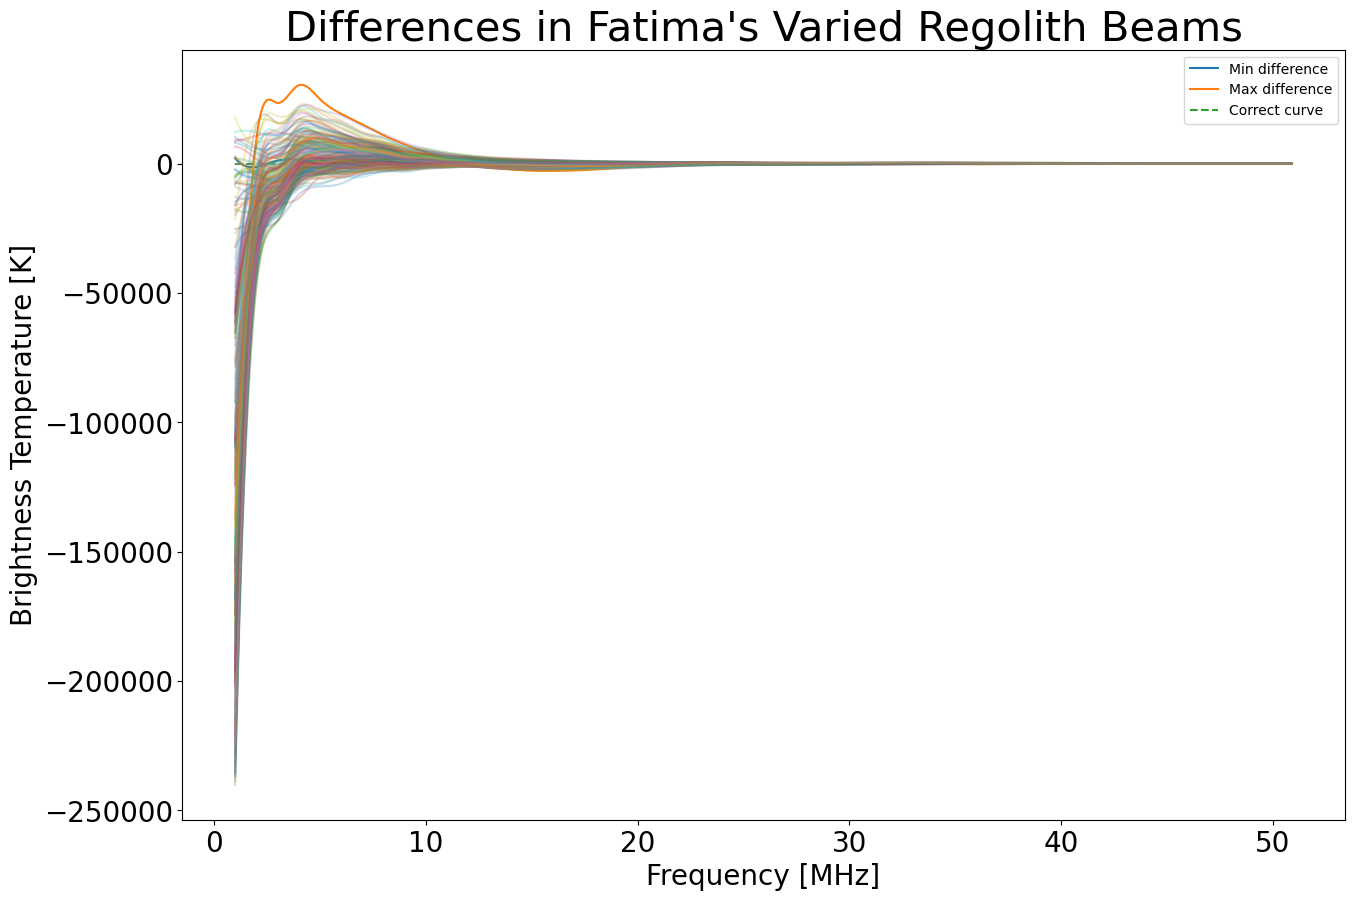

In [247]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.plot(np.arange(1,51,(50/len(varied_regolith_training_set[0][0]))),varied_regolith_training_set[155][0]-varied_regolith_training_set[151][0],label="Min difference")   # I'm getting rid of the 0 M
plt.plot(np.arange(1,51,(50/len(varied_regolith_training_set[0][0]))),varied_regolith_training_set[155][0]-varied_regolith_training_set[71][0],label="Max difference")
plt.plot(np.arange(1,51,(50/len(varied_regolith_training_set[0][0]))),varied_regolith_training_set[155][0]-varied_regolith_training_set[155][0],label="Correct curve",ls="--")
for i in range(len(varied_regolith_training_set)):
    if (i !=151) & (i != 71):
        plt.plot(np.arange(1,51,(50/len(varied_regolith_training_set[0][0]))),varied_regolith_training_set[155][0]-varied_regolith_training_set[i][0],alpha=0.25)
# plt.yscale("log")
plt.title("Differences in Fatima's Varied Regolith Beams",size=30)
plt.xlabel("Frequency [MHz]",size=20)
plt.ylabel("Brightness Temperature [K]",size=20)
# plt.yscale("log")
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend()
plt.savefig("Fatima_Varied_Regolith_Signal_diffences")

### A Few Notes:
- It seems that PYLINEX can absolutely extract the signal with a very accurate value if you play with the number of terms it uses. Now this may seem like an easy thing to do, but if you think about the data you'll be getting from an instrument, you don't know the correct answer, so you have to believe it's using the correct number of terms. It's an issue. I'm going to try to subvert it by finding the best fit foreground using PYLINEX, then use that as the answer for fitting the signal.

- So fitting the foreground first and then either subtracting that or using that as the vector answer didn't go well (neither went well). It works best when we use BPIC and just let it fit both at the same time. It's always within around 1 sigma of the error, which is fine. I think that is the best we can expect.  Let's move forward because this seems like it's going to work just fine. We just have to keep those errors in mind when we do the next step.

### Appendices

In [16]:

def extract_parameters_from_name (path):
    """Extracts parameters from the names of Fatima's beams and adds them back into the fits header
    
    Parameters
    =======================================================
    Path: The file that contains all of the beams
    
    Returns
    =======================================================
    Nothing, but it does update all of the beam fits files with the parameters of that beam for later training set use"""
    files = []
    file_names = []
    for file in os.listdir(path):     # creates our list of file names and full file paths
        files.append(path+"/"+file)
        file_names.append(file)
    for i,j in zip(files,file_names):     # goes through each file name and pulls out the parameter values from Fatima's file naming convention.
        separation_indices = [i for i, value in enumerate(j) if value == '_']
        ### L ###
        L_index = j.index("L")
        L_string = j[L_index:separation_indices[0]]
        p_index=False
        try:
            p_index = L_string.index("p")
        except ValueError:
            pass
        if p_index:
            L_string=L_string.replace("p",".")
        L = float(L_string[1:])
        ### TOP ###
        top_string = j[separation_indices[1]+1:separation_indices[2]]
        p_index=False
        try:
            p_index = top_string.index("p")
        except ValueError:
            pass
        if p_index:
            top_string=top_string.replace("p",".")
        TOP = float(top_string[0:])
        ### BOTTOM ###
        bottom_string = j[separation_indices[3]+1:j.index(".")]
        p_index=False
        try:
            p_index = bottom_string.index("p")
        except ValueError:
            pass
        if p_index:
            bottom_string=bottom_string.replace("p",".")
        BOTTOM = float(bottom_string[0:])
        with fits.open(i, mode='update') as hdul:
            # Access and modify header with our parameters
            hdul[0].header.append(("L",L))
            hdul[0].header.append(("TOP",TOP))
            hdul[0].header.append(("BOTTOM",BOTTOM))

    return

In [ ]:
# # Let's loop through all the data we've been given and make a beam visualization per frequency:

# # ### Uncomment this to create or update your hdf5 files for the beams.  NOTE: this will take around 80 minutes to run ####

path_difference_array = path_difference(500,75000,500)

# Dipole EW phase 180
pathbase_dipole_EW_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/dipole_EW_Phase180deg/GainPlot_02_dipole_EW_Phase180deg/GainPlot_02_"
pathend_dipole_EW_p180 = "kHz_dipole_EW_Phase180deg.csv"
gbeam_dipole_EW_p180 = beam_master_array(pathbase_dipole_EW_p180,path_difference_array,pathend_dipole_EW_p180)

# Dipole NS phase 180
pathbase_dipole_NS_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/dipole_NS_Phase180deg/GainPlot_02_dipole_NS_Phase180deg/GainPlot_02_"
pathend_dipole_NS_p180 = "kHz_dipole_NS_Phase180deg.csv"
gbeam_dipole_NS_p180 = beam_master_array(pathbase_dipole_NS_p180,path_difference_array,pathend_dipole_NS_p180)

# Monopole E
pathbase_monopole_E = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_E/GainPlot_02_monopole_E_Phase0deg/GainPlot_02_"
pathend_monopole_E = "kHz_monopole_E_Phase0deg.csv"
gbeam_monopole_E = beam_master_array(pathbase_monopole_E,path_difference_array,pathend_monopole_E)

# Monopole N
pathbase_monopole_N = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_N/GainPlot_02_monopole_N_Phase0deg/GainPlot_02_"
pathend_monopole_N = "kHz_monopole_N_Phase0deg.csv"
gbeam_monopole_N = beam_master_array(pathbase_monopole_N,path_difference_array,pathend_monopole_N)

# Monopole S
pathbase_monopole_S = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_S/GainPlot_02_monopole_S_Phase0deg/GainPlot_02_"
pathend_monopole_S = "kHz_monopole_S_Phase0deg.csv"
gbeam_monopole_S = beam_master_array(pathbase_monopole_S,path_difference_array,pathend_monopole_S)

# Monopole W
pathbase_monopole_W = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_W/GainPlot_02_monopole_W_Phase0deg/GainPlot_02_"
pathend_monopole_W = "kHz_monopole_W_Phase0deg.csv"
gbeam_monopole_W = beam_master_array(pathbase_monopole_W,path_difference_array,pathend_monopole_W)

# Orthogonal Dipole ES Phase 180
pathbase_dipole_ES_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_ES_Phase180deg/GainPlot_02_dipole_ES_Phase180deg/GainPlot_02_"
pathend_dipole_ES_p180 = "kHz_dipole_ES_Phase180deg.csv"
gbeam_dipole_ES_p180 = beam_master_array(pathbase_dipole_ES_p180,path_difference_array,pathend_dipole_ES_p180)

# Orthogonal Dipole NE Phase 180
pathbase_dipole_NE_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_NE_Phase180deg/GainPlot_02_dipole_NE_Phase180deg/GainPlot_02_"
pathend_dipole_NE_p180 = "kHz_dipole_NE_Phase180deg.csv"
gbeam_dipole_NE_p180 = beam_master_array(pathbase_dipole_NE_p180,path_difference_array,pathend_dipole_NE_p180)

# Orthogonal Dipole SW Phase 180
pathbase_dipole_SW_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_SW_Phase180deg/GainPlot_02_dipole_SW_Phase180deg/GainPlot_02_"
pathend_dipole_SW_p180 = "kHz_dipole_SW_Phase180deg.csv"
gbeam_dipole_SW_p180 = beam_master_array(pathbase_dipole_SW_p180,path_difference_array,pathend_dipole_SW_p180)

# Orthogonal Dipole WN Phase 180
pathbase_dipole_WN_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_WN_Phase180deg/GainPlot_02_dipole_WN_Phase180deg/GainPlot_02_"
pathend_dipole_WN_p180 = "kHz_dipole_WN_Phase180deg.csv"
gbeam_dipole_WN_p180 = beam_master_array(pathbase_dipole_WN_p180,path_difference_array,pathend_dipole_WN_p180)

# ### Store as HDF5 Files so we don't have to actually run the above more than once:
f = h5py.File("/home/dbarker7752/21_cm_group/Beam_Plots/Healpy_Beam_Arrays","w")
dset01 = f.create_dataset("Dipole EW Phase 180",data=gbeam_dipole_EW_p180[0])
dset02 = f.create_dataset("Dipole NS Phase 180",data=gbeam_dipole_NS_p180[0]) 
dset03 = f.create_dataset("Monopole E Phase 0",data=gbeam_monopole_E[0])
dset04 = f.create_dataset("Monopole N Phase 0",data=gbeam_monopole_N[0])
dset05 = f.create_dataset("Monopole S Phase 0",data=gbeam_monopole_S[0])
dset06 = f.create_dataset("Monopole W Phase 0",data=gbeam_monopole_W[0])
dset07 = f.create_dataset("Dipole ES Phase 180",data=gbeam_dipole_ES_p180[0]) 
dset08 = f.create_dataset("Dipole NE Phase 180",data=gbeam_dipole_NE_p180[0])
dset09 = f.create_dataset("Dipole SW Phase 180",data=gbeam_dipole_SW_p180[0])
dset10 = f.create_dataset("Dipole WN Phase 180",data=gbeam_dipole_WN_p180[0] )

In [ ]:
# load up the data within the hdf5 files
f = h5py.File("/home/dbarker7752/21_cm_group/Beam_Plots/Healpy_Beam_Arrays","r")
gbeam_dipole_EW_p180_hp = f["Dipole EW Phase 180"]
gbeam_dipole_NS_p180_hp = f["Dipole NS Phase 180"]
gbeam_monopole_E_hp = f["Monopole E Phase 0"]
gbeam_monopole_N_hp = f["Monopole N Phase 0"]
gbeam_monopole_S_hp = f["Monopole S Phase 0"]
gbeam_monopole_W_hp = f["Monopole W Phase 0"]
gbeam_dipole_ES_p180_hp = f["Dipole ES Phase 180"]
gbeam_dipole_NE_p180_hp = f["Dipole NE Phase 180"]
gbeam_dipole_SW_p180_hp = f["Dipole SW Phase 180"]
gbeam_dipole_WN_p180_hp = f["Dipole WN Phase 180"]